## Clustering Student Learning Behaviors

Before predicting grades, I wanted to explore whether **students naturally group into distinct learning behavior profiles** based on motivation, access, and engagement.

Rather than assuming all student behave the same way, clustering allows us to:

- Identify **behavioral patterns**
- Understand **heterogeneity** in learning habits
- Provide context for later predictive modeling

In [23]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("../data/cleaned_student_performance.csv")


In [24]:
categorical_cols = ['Motivation', 'Resources', 'Extracurricular', 'Internet', 'Gender', 'LearningStyle', 'Discussions', 'EduTech', 'FinalGrade']

for col in categorical_cols:
    data[col] = data[col].astype('category')

## Feature Selectio for Clustering

For clustering, I focused on **behavioral and access-related features** rather than performance outcomes.

Selected features:

- Motivation
- Resources
- Internet
- Discussions

These variables reflect:

- Internal drive
- Access to learning tools
- Engagement woth instructional supports

All features were **standardized** prior to clustering to ensure equal contribution.

In [25]:
features = ['Motivation', 'Resources', 'Discussions', 'Internet']

X = data[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Choosing the Number of Clusters

### Elbow Method

To determine an appropriate number of clusters (K), I evaluated model inertia across values of K = 2-9.

The elbow plot show a **sharp reduction in inertia around K=5**, followed by diminishing returns.

This suggest that increasing clusters beyond this point adds limited explanatory value.

<function matplotlib.pyplot.show(close=None, block=None)>

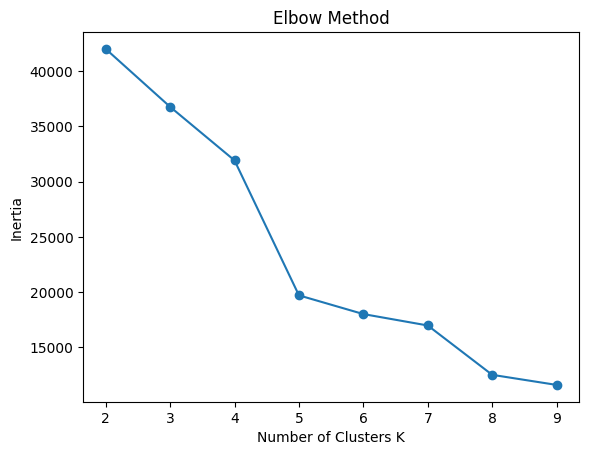

In [ ]:
inertia = []
K_range = range(2, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters K')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

## Silhouette Score Validation

To compliment the elbow method, I computed **silhoutte scores** for each value of K.

Silhouette scores measure:

- How well-separated clusters are
- How similar points are within the same cluster

Higher scores indicated better-defined clusters.

While multiple values performed reasonably well, **K=8** provided:

- Strong separation
- Meaningful subgroup distinctions

In [ ]:
from sklearn.metrics import silhouette_score

for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    print(f"K={k}, silhouette score={sil:.3f}")

K=2,, silhouette score=0.331
K=3,, silhouette score=0.311
K=4,, silhouette score=0.347
K=5,, silhouette score=0.420
K=6,, silhouette score=0.445
K=7,, silhouette score=0.440
K=8,, silhouette score=0.520
K=9,, silhouette score=0.538


## Final Clustering with K-Means

Based on the evaluation, I selected **K=8** clusters.

Each student was assigned to a cluster representing a distinct combination of:

- Motivation
- Access
- Engagement behaviors

These clusters represent **learning behavior profiles**, not ability levels.

In [28]:
best_k = 8
kmeans = KMeans(n_clusters=best_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)

In [29]:
cols = ['Motivation', 'Internet', 'Resources', 'Discussions']

for c in cols:
    if str(data[c].dtype) == 'category':
        data[c].cat.codes

data[cols] = data[cols].astype('int64')

cluster_summary = (
    data.groupby('Cluster')[cols].mean().round(2)
)

cluster_summary

,Motivation,Internet,Resources,Discussions
Cluster,,,,
0,2.00,1.0,1.34,1.00
1,1.29,1.0,1.38,0.00
2,1.00,1.0,2.00,1.00
3,1.11,1.0,0.66,1.00
4,0.88,0.0,1.16,0.62
5,0.00,1.0,1.06,1.00
6,1.27,1.0,0.00,0.00
7,0.00,1.0,1.09,0.00


## Cluster Profiles (Behavioral Summary)

To interpret the clusters, I examined the **average behavior levels within each group**

Key observations:

- Some clusters show **high motivation but low resources**
- Others reflect **low engagement despite adequate access**
- Several clusters exhibit mixed patterns rather than extremes

This reinforces that learning behavior is **multidimensional**, not binary.

In [30]:
pd.crosstab(data['Cluster'], data['FinalGrade'], normalize='index')

FinalGrade,0,1,2,3
Cluster,,,,
0,0.255870,0.225911,0.272874,0.245344
1,0.297937,0.228610,0.247548,0.225905
2,0.256158,0.233169,0.257800,0.252874
3,0.265279,0.239181,0.265279,0.230261
4,0.264621,0.264621,0.254075,0.216683
5,0.254453,0.240458,0.269720,0.235369
6,0.305898,0.237311,0.230453,0.226337
7,0.293175,0.230501,0.252786,0.223538


## Cluster vs. FinalGrade Distribution

I then compared clusters against **FinalGrade distributions**.

Important insight:

**No cluster maps cleanly to a single grade outcome.**

Each cluster contains a spread of performance levels, suggesting:

- Behavior patterns influence outcomes
- But **do not determine them outright**

This finding supports the idea that clustering provides **context**, not prediction.

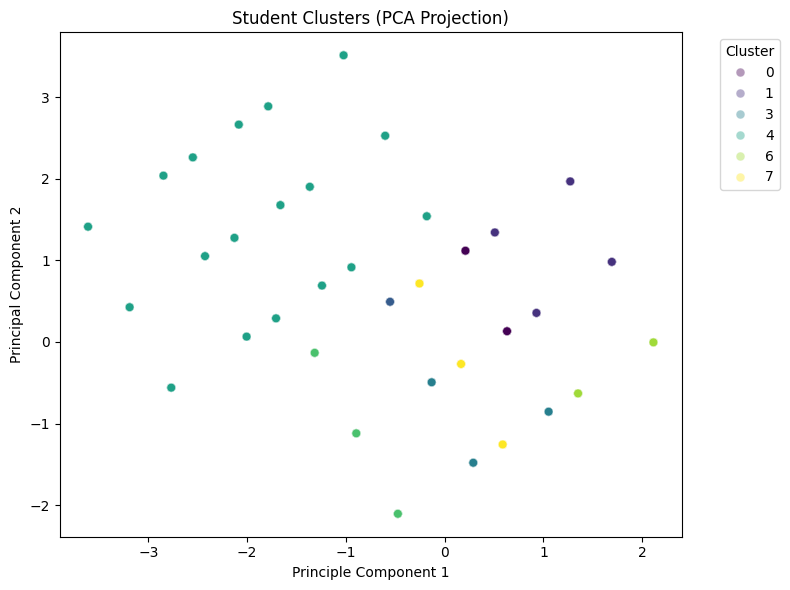

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

data['PC1'] = X_pca[:,0]
data['PC2'] = X_pca[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=data, 
    x='PC1', 
    y='PC2', 
    hue='Cluster', 
    palette='viridis', 
    alpha=0.4,
    s=40
    )
plt.title('Student Clusters (PCA Projection)')
plt.xlabel('Principle Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Visualizing Clusters with PCA

To better understand cluster separation, I applied **Principal Component Analysis (PCA)** to project the data into two dimensions.

The PCA plot shows:

- Moderate overlap between clusters
- Clear grouping tendencies
- No singel dominant axis explaining performance

This highlights the **complex, interacting nature** of student behaviors.


In [34]:
data.to_csv("../data/student_clusters.csv", index=False)

## Key Takeaways from Clustering

- Students exhibit **distinct learning behavior profiles**
- Access, motivation, and engagement interact in non-linear ways
- Clusters provide **context**, not labels
- These insights informed feature engineering and downstream modeling

---

## Next Step

With behavioral patterns established, the next phase explores:

**Can we predict academic outcomes when we combine behavior, engagement, and engineered features?**

This leads into supervised modeling and feature important analysis.